In [2]:
!pip install ucimlrepo

#Imports

In [77]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

#Get the first dataset (1.1/2)

In [92]:
# load the datasets
itt = fetch_ucirepo(id=925)

# split the data into features and targets
X = itt.data.features
y = itt.data.targets

# get rid of the extra target
y = y.drop('aveOralF', axis=1)

# get all columns into catagorial and numerical
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns

# label encoding
label_encoder = LabelEncoder()
for col in cat_cols:
    X[col] = label_encoder.fit_transform(X[col])

# scale the numerical data
scaler = StandardScaler()
scaled = scaler.fit_transform(X)
X = pd.DataFrame(scaled, columns=X.columns)

# remove null value rows
Xi = X.dropna()

# need to drop those outcome rows too
yi = y.loc[Xi.index]

# replace true and false with 0 and 1
Xi = Xi.replace({True: 1, False: 0})

# get column names for later
colsi = Xi.columns

# convert to numpy arrays
Xi = Xi.to_numpy()
yi = yi.to_numpy()
yi = yi.T[0]

<ipython-input-92-19fc7441c9c9>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = label_encoder.fit_transform(X[col])
<ipython-input-92-19fc7441c9c9>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = label_encoder.fit_transform(X[col])
<ipython-input-92-19fc7441c9c9>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

# Basic statistics on dataset 1 (1.3)

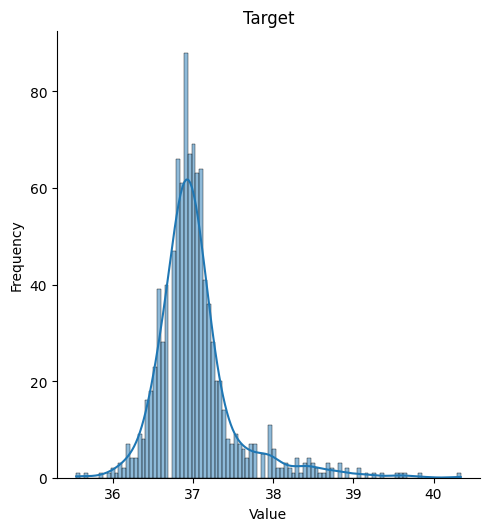

avg: 37.028163064833
std: 0.5094922786993548


In [253]:
# plot distribution for outcome
sns.displot(yi, kde=True, bins=100)
plt.title('Target')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()
print('avg:', np.mean(yi))
print('std:', np.std(yi))

As can be seen in the distributiion, most of the samples are within 36 to 38 degrees celcius.

#Implimentation of analytical linear regression model (2.1)



In [112]:
class LinearRegression:
    def __init__(self):
        pass

    def fit(self, x, y):
        # add bias features
        x = np.column_stack([x,np.ones(x.shape[0])])

        # update the weights
        self.w = ((np.linalg.inv(x.T@x))@x.T)@y
        return self

    def predict(self, x):
        # add bias feature
        x = np.column_stack([x,np.ones(x.shape[0])])
        # make prediction
        yh = x@self.w
        return yh

#Task 3.1: Report the performance of linear regression on a 80−20 train/test split and report the performance on both training set and test set.




In [95]:
# split data into train and test sets 80/20
Xi_train, Xi_test, yi_train, yi_test = train_test_split(Xi, yi, test_size=0.2, random_state=42)

# train the model on the train set
model = LinearRegression()
model.fit(Xi_train, yi_train)

# get the train set prediction
yhi_train = model.predict(Xi_train)

# get the test set prediction
yhi_test = model.predict(Xi_test)

# calculate the performance
mse_train = mean_squared_error(yi_train, yhi_train)
mse_test = mean_squared_error(yi_test, yhi_test)

r2_train = r2_score(yi_train, yhi_train)
r2_test = r2_score(yi_test, yhi_test)

# display the results
print('train set:')
print("mean squared error: ", mse_train)
print("r2 score: ", r2_train)
print()
print('test set:')
print("mean squared error: ", mse_test)
print("r2 score: ", r2_test)



train set:
mean squared error:  0.06239455596506735
r2 score:  0.7728967593649053

test set:
mean squared error:  0.06519712929389679
r2 score:  0.6722470582564084


#Task 3.2: Report the weights of each of features in your trained models and discuss how each feature could affect the performance of the models.

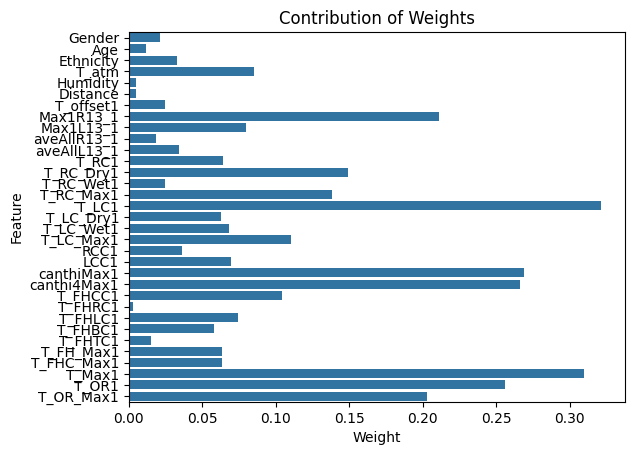

The top 5 most contributing features:  ['T_LC1' 'T_Max1' 'canthiMax1' 'canthi4Max1' 'T_OR1']


In [267]:
# split data into train and test sets
Xi_train, Xi_test, yi_train, yi_test = train_test_split(Xi, yi, test_size=0.2, random_state=42)

# train the model and get predictions
model = LinearRegression()
model.fit(Xi_train, yi_train)

# get the trained weights
w = model.w

# get rid of bias weight
w = w[:-1]

# turn all weights positive to better comapare them
w = np.abs(w)

# visualize the weights
sns.barplot(y=colsi, x=w)
plt.title('Contribution of Weights')
plt.xlabel('Weight')
plt.ylabel('Feature')
plt.show()

# find the top 5 most contribution features
top5 = colsi[np.argsort(w)[-5:]].to_numpy()[::-1]

print("The top 5 most contributing features: ", top5)

#Task 2.3: Implimentation of Mini-batch linear regression.

In [209]:
class LinearRegressionMB:
    def __init__(self, lr=0.01, epochs=100, epsilon=1e-8, bs=128, w=None, history = {'loss': []}):
        self.lr = lr
        self.epochs = epochs
        self.epsilon = epsilon
        self.bs = bs
        self.w = w
        self.history = history
        pass

    def fit(self, x, y):
        # add the bias feature
        N = x.shape[0]
        x = np.column_stack([x,np.ones(N)])

        N,D = x.shape

        # init weights to 0s
        self.w = np.zeros(D)
        grad = np.inf
        t = 1
        N = len(y)
        while t < self.epochs and np.linalg.norm(grad) > self.epsilon:
        #for epoch in range(self.epochs):
            # shuffle data
            idx = np.random.permutation(N)
            Xs = x[idx]
            ys = y[idx]

            # do a step of gradient descent for every minibatch
            for i in range(0, N, self.bs):
                # create the current mini-batch
                xb = Xs[i:(i+self.bs)]
                yb = ys[i:(i+self.bs)]

                # calculate the gradient
                grad = 2 / len(xb) * np.dot(xb.T, np.dot(xb, self.w) - yb)

                # update the weights
                self.w -= self.lr * grad

            # calc the loss and add it to history
            loss = 0.5 * np.linalg.norm(y - np.dot(x, self.w)) ** 2
            self.history['loss'].append(loss)

            # increase index
            t += 1
        return self

    def predict(self, x):
        N = x.shape[0]
        x = np.column_stack([x,np.ones(N)])
        yh = np.dot(x, self.w)
        return yh

# Test Mini-batch for 80/20 split

100


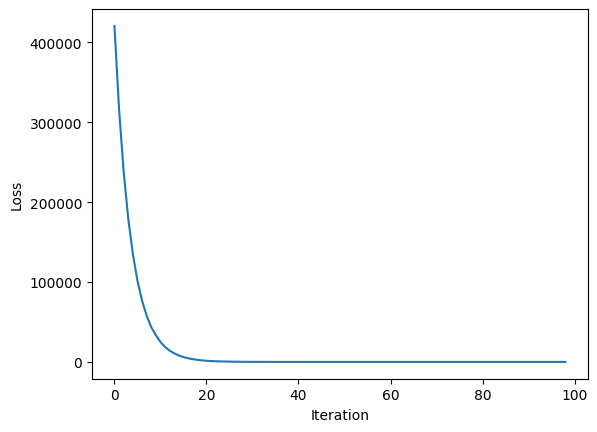

mean squared error:  0.06852817182430211
r2:  0.655501551203607


In [182]:
# split data into train and test sets
Xi_train, Xi_test, yi_train, yi_test = train_test_split(Xi, yi, test_size=0.2, random_state=42)

# train the model and get predictions
model = LinearRegressionMB(history = {'loss': []})
model.fit(Xi_train, yi_train)
yhi = model.predict(Xi_test)

# get loss history
hist = model.history
# plot grad
plt.plot(hist['loss'])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

# display results
mse = mean_squared_error(yi_test, yhi)
r2 = r2_score(yi_test, yhi)

print("mean squared error: ", mse)
print("r2: ", r2)

#Task 3.3: Test mini batch linear regression with growing training sets.

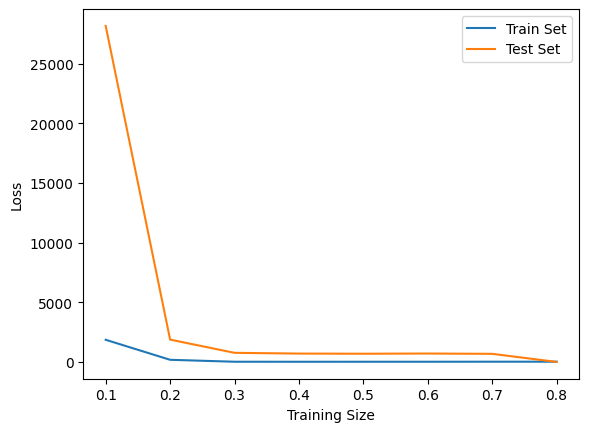

In [268]:
train_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
loss_scores = {'train': [], 'test': []}

for i in range(1, 9):
  # get the test_size
  size = (10-i)*0.1

  # split data into train and test sets
  Xi_train, Xi_test, yi_train, yi_test = train_test_split(Xi, yi, test_size=size, random_state=42)

  # train the model on the current train size
  model = LinearRegressionMB()
  model.fit(Xi_train, yi_train)

  # make predictions for the train set
  yhi_train = model.predict(Xi_train)

  # get the loss for the train set
  train_loss = 0.5 * np.linalg.norm(yi_train - yhi_train) ** 2

  # append loss to loss scores array
  loss_scores['train'].append(train_loss)

  # make predictions for the test set
  yhi_test = model.predict(Xi_test)

  # get the loss for the test set
  test_loss = 0.5 * np.linalg.norm(yi_test - yhi_test) ** 2

  # append loss to loss scores array
  loss_scores['test'].append(test_loss)

# plot make the plots for the loss as a function of training set size
plt.plot(train_sizes, loss_scores['train'], label='Train Set')
plt.plot(train_sizes, loss_scores['test'], label='Test Set')
plt.xlabel('Training Size')
plt.ylabel('Loss')
plt.legend()
plt.show()


As can be seen in the graph, is that losses for both the training set and testing set decrease as the training set size increases.

#Task 3.4: Test linear regression mini batch with growing batch sizes.


final loss: 29.448357005810937
reached loss of 35 at epoch:  5


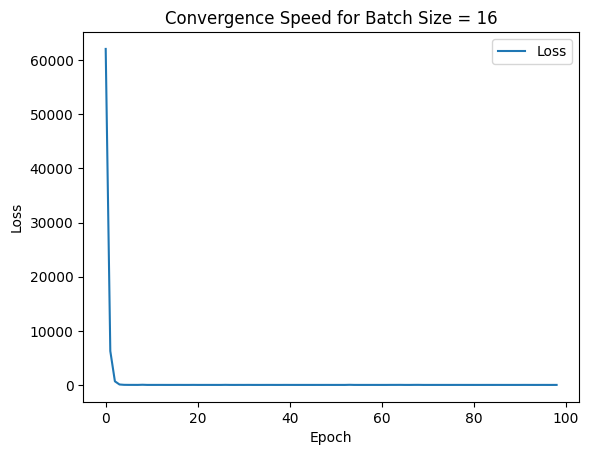


final loss: 28.123203860884328
reached loss of 35 at epoch:  11


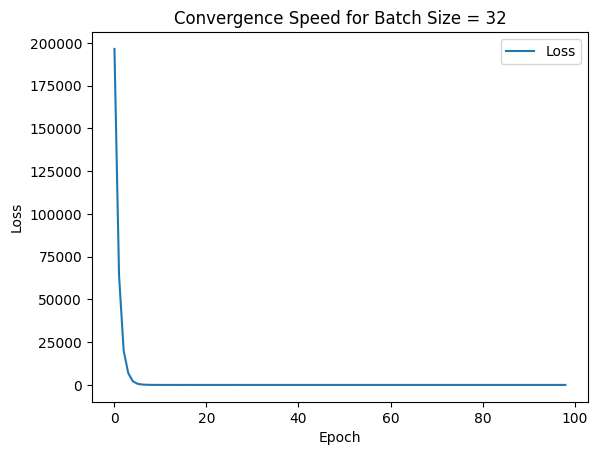


final loss: 29.157646177238604
reached loss of 35 at epoch:  22


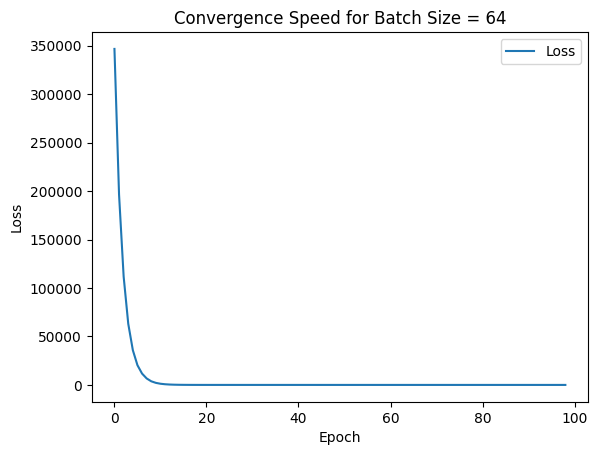


final loss: 29.16774477905033
reached loss of 35 at epoch:  44


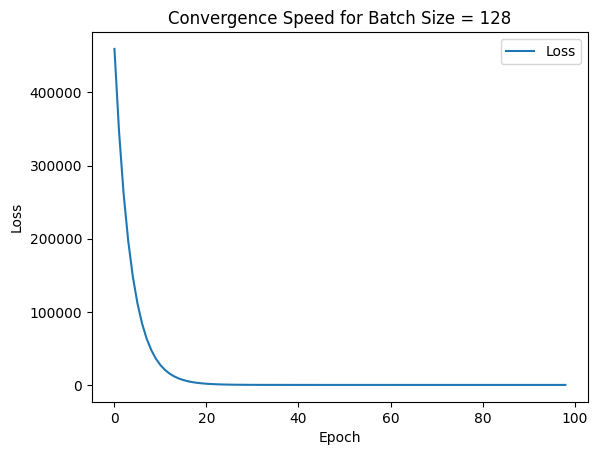


Best Final loss for mini-batch:  28.123203860884328
Final loss for analytical:  4.0351327190641015


In [278]:
batch_sizes = [16, 32, 64, 128]
final_losses = []

# split data into train and test sets
Xi_train, Xi_test, yi_train, yi_test = train_test_split(Xi, yi, test_size=size, random_state=42)

for i in range(0, 4):
  # get the batch size
  size = batch_sizes[i]

  # train the model and get predictions
  model = LinearRegressionMB(bs=size, history = {'loss': []})
  yhi = model.fit(Xi_train, yi_train).predict(Xi_test)

  # get the convergence speed (basicly the list of loss functions to see how fast it approches 0)
  loss_speed = model.history['loss']

  print()
  print('final loss:', loss_speed[-1])

  # find where loss is less than 35
  for j in range(0, len(loss_speed)):
    if loss_speed[j] < 35:
      print('reached loss of 35 at epoch: ', j)
      break

  # plot the convergence speed for the current batch size
  plt.plot(loss_speed, label='Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Convergence Speed for Batch Size = ' + str(size))
  plt.legend()
  plt.show()

  final_losses.append(loss_speed[-1])

# compare with analytical linear regression
model = LinearRegression()
yhi = model.fit(Xi_train, yi_train).predict(Xi_test)


# get loss
loss = 0.5 * np.linalg.norm(yi_test - yhi) ** 2
print()
print('Best Final loss for mini-batch: ', min(final_losses))
print('Final loss for analytical: ', loss)



As you can see in the above plots. The higher the batch size, the longer it takes to converge. But overall the final loss for the analytical solution is much lower than any of the mini-batch solutions. So the best configuration for linear regression would be the analytical solution.

#Task 3.5: Test linear regression mini batch with 3 different learning rates.

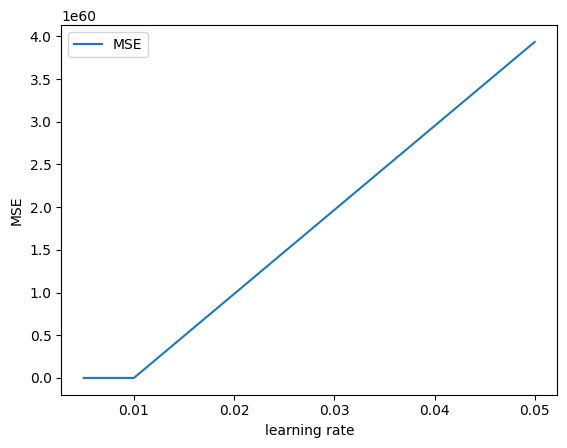

In [234]:
lrs = [0.005, 0.01, 0.05]
r2_scores = []
mse_scores = []

# split data into train and test sets
Xi_train, Xi_test, yi_train, yi_test = train_test_split(Xi, yi, test_size=size, random_state=42)

for i in range(0, 3):
  # get the lr
  lr = lrs[i]

  # train the model and get predictions
  model = LinearRegressionMB(lr=lr, epochs=100)
  yhi = model.fit(Xi_train, yi_train).predict(Xi_test)

  # get metrics
  mse = mean_squared_error(yi_test, yhi)
  r2 = r2_score(yi_test, yhi)
  r2_scores.append(r2)
  mse_scores.append(mse)

# plot the curves
#plt.plot(lrs, r2_scores, label='R2')
plt.plot(lrs, mse_scores, label='MSE')
plt.xlabel('learning rate')
plt.ylabel('MSE')
plt.legend()
plt.show()

#Task 3.6: Compare analytical linear regression with mini batch

In [242]:
# split data into train and test sets 80/20
Xi_train, Xi_test, yi_train, yi_test = train_test_split(Xi, yi, test_size=0.2, random_state=42)

# Analytical

# train the model on the train set
model = LinearRegression()
model.fit(Xi_train, yi_train)

# get the train set prediction
yhi_train = model.predict(Xi_train)

# get the test set prediction
yhi_test = model.predict(Xi_test)

# calculate the performance
mse_train = mean_squared_error(yi_train, yhi_train)
mse_test = mean_squared_error(yi_test, yhi_test)

r2_train = r2_score(yi_train, yhi_train)
r2_test = r2_score(yi_test, yhi_test)

# display the results
print('Analytical:')
print()
print('train set:')
print("mean squared error: ", mse_train)
print("r2 score: ", r2_train)
print()
print('test set:')
print("mean squared error: ", mse_test)
print("r2 score: ", r2_test)
print()
print()
# Mini-Batch

# train the model on the train set
model = LinearRegressionMB()
model.fit(Xi_train, yi_train)

# get the train set prediction
yhi_train = model.predict(Xi_train)

# get the test set prediction
yhi_test = model.predict(Xi_test)

# calculate the performance
mse_train = mean_squared_error(yi_train, yhi_train)
mse_test = mean_squared_error(yi_test, yhi_test)

r2_train = r2_score(yi_train, yhi_train)
r2_test = r2_score(yi_test, yhi_test)

# display the results
print('Mini-Batch:')
print()
print('train set:')
print("mean squared error: ", mse_train)
print("r2 score: ", r2_train)
print()
print('test set:')
print("mean squared error: ", mse_test)
print("r2 score: ", r2_test)

Analytical:

train set:
mean squared error:  0.06239455596506735
r2 score:  0.7728967593649053

test set:
mean squared error:  0.06519712929389679
r2 score:  0.6722470582564084


Mini-Batch:

train set:
mean squared error:  0.0677203636462703
r2 score:  0.7535119241866947

test set:
mean squared error:  0.07137789474149765
r2 score:  0.6411756893231759


It seems that the analytical approach slightly outpreforms the mini-batch version. This is because using the closed solution you can calculate the exact weights that minimize the cost function, where in the mini-batch solution it is an approximation.

#Get the second dataset (1.2)

In [260]:
# load the datasets
itt = fetch_ucirepo(id=891)

# split the data into features and targets
X = itt.data.features
y = itt.data.targets

# scale the numerical data
scaler = StandardScaler()
#scaled_numerical = pd.DataFrame(scaler.fit_transform(X[num_cols]), columns=num_cols)
#X[X.columns] = scaler.fit_transform(X[X.columns])

# remove null value rows
Xd = X.dropna()

# need to drop those outcome rows too
yd = y.loc[Xd.index]

# cast as lower type
Xd = Xd.astype('int8')
yd = yd.astype('int8')

# get the columns
colsd = Xd.columns

# convert to numpy arrays
Xd = Xd.to_numpy()
yd = yd.to_numpy()

yd = yd.T[0]


# Basic statistics for dataset 2 (1.3)

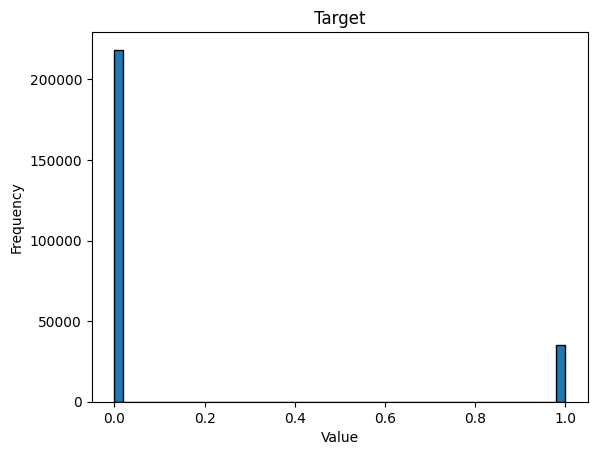

In [255]:
# plot distribution for outcome
plt.hist(yd, bins=50, edgecolor='black')
plt.title('Target')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

print('number of outcomes with diabetes:', np.sum(yd == 1))
print('number of outcomes without diabetes:', np.sum(yd == 0))

#Impliment logistic regression with GD

In [194]:
logistic = lambda z: 1./ (1 + np.exp(-z))       #logistic function

class LogisticRegression:
    def __init__(self, lr=0.1, epsilon=1e-4, epochs=1000, history = {'loss': []}):
        self.lr = lr
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients
        self.epochs = epochs                    #maximum number of iteration of gradient descent
        self.history = history

    def fit(self, x, y):
        # add the bias feature
        x = np.column_stack([x,np.ones(x.shape[0])])

        # get number of samples and features
        N,D = x.shape

        # init weights to 0
        self.w = np.zeros(D)
        g = np.inf
        t = 0
        # the code snippet below is for gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.epochs:
            # calc gradient
            g = 2 / len(x) * np.dot(x.T, logistic(np.dot(x, self.w)) - y)

            # update weights
            self.w -= self.lr * g

            # calc loss and add to history
            loss = 0.5 * np.linalg.norm(y - logistic(np.dot(x, self.w))) ** 2
            self.history['loss'].append(loss)
            t += 1
        return self

    def predict(self, x):
        # add bias feature
        x = np.column_stack([x,np.ones(x.shape[0])])
        # make prediction
        yh = logistic(np.dot(x,self.w))
        return yh

#Task 3.1: Report the performance of logistic regression on a 80−20 train/test split and report the performance on both training set and test set.

In [261]:
# split data into train and test sets
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size=0.2, random_state=42)

# train the model on the train set
model = LogisticRegression()
model.fit(Xd_train, yd_train)

# get the train set predicitons
yhd_train = model.predict(Xd_train)

# get the test set predicitons
yhd_test = model.predict(Xd_test)

# calculate performance
acc_train = accuracy_score(yd_train, yhd_train.astype(int))
acc_test = accuracy_score(yd_test, yhd_test.astype(int))

# display results
print('train set:')
print("accuracy: ", acc_train)
print()
print('test set:')
print("accuracy: ", acc_test)



train set:
accuracy:  0.8603112188584043

test set:
accuracy:  0.8620900346893724


#Task 3.2: Report the weights of each of features in your logistic model and discuss how each feature could affect the performance of the models.

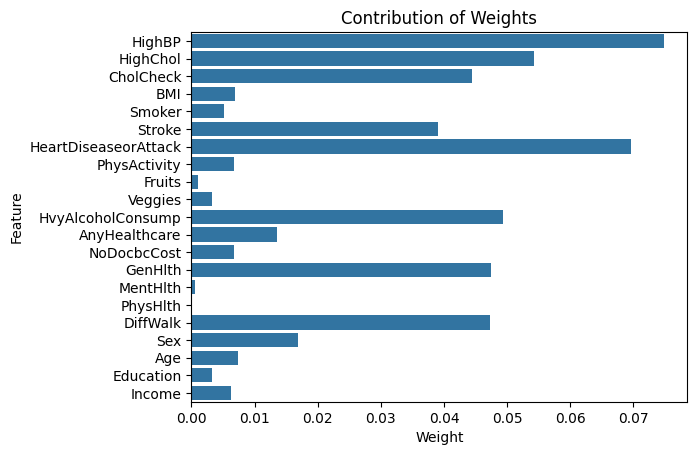

The top 5 most contributing features:  ['HighBP' 'HeartDiseaseorAttack' 'HighChol' 'HvyAlcoholConsump' 'GenHlth']


In [266]:
# split data into train and test sets
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size=0.2, random_state=42)

# train the model and get predictions
model = LinearRegression()
model.fit(Xd_train, yd_train)

# get the trained weights
w = model.w

# get rid of bias weight
w = w[:-1]

# turn all weights positive to better comapare them
w = np.abs(w)

# visualize the weights
sns.barplot(y=colsd, x=w)
plt.title('Contribution of Weights')
plt.xlabel('Weight')
plt.ylabel('Feature')
plt.show()

# find the top 5 most contribution features
top5 = colsd[np.argsort(w)[-5:]].to_numpy()[::-1]

print("The top 5 most contributing features: ", top5)

#Impliment logistic regression with mini batch GD

In [257]:
logistic = lambda z: 1./ (1 + np.exp(-z))       #logistic function

def cost_fn(x, y, w):
    N, D = x.shape
    z = np.dot(x, w)
    J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))  #log1p calculates log(1+x) to remove floating point inaccuracies
    return J

class LogisticRegressionMB:
    def __init__(self, lr=0.1, epsilon=1e-4, epochs=1000, bs=128, history={'loss': []}):
        self.lr = lr
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients
        self.epochs = epochs                    #maximum number of iteration of gradient descent
        self.bs = bs
        self.history = history

    def fit(self, x, y):
        # add bias feature
        x = np.column_stack([x,np.ones(x.shape[0])])
        N,D = x.shape

        # init weights to zero
        self.w = np.zeros(D)
        g = np.inf
        t = 0
        # the code snippet below is for gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.epochs:
            # shuffle data
            N = x.shape[0]
            idx = np.random.permutation(N)
            Xs = x[idx]
            ys = y[idx]

            # do a step of gradient descent for every minibatch
            for i in range(0, N, self.bs):
              # create the mini batches
              xb = Xs[i:(i+self.bs)]
              yb = ys[i:(i+self.bs)]

              # calculate the gradient
              g = 2 / len(xb) * np.dot(xb.T, logistic(np.dot(xb, self.w)) - yb)

              # update the weights
              self.w -= self.lr * g

            # calculate the loss and add to history
            loss = 0.5 * np.linalg.norm(y - logistic(np.dot(x, self.w))) ** 2
            self.history['loss'].append(loss)
            t += 1
        return self

    def predict(self, x):
        # add bias feature
        x = np.column_stack([x,np.ones(x.shape[0])])
        # make prediction
        yh = logistic(np.dot(x,self.w))
        return yh


#Task 3.3: Test logistic regression mini batch with growing training sets.

1  out of 8 done
2  out of 8 done
3  out of 8 done
4  out of 8 done
5  out of 8 done
6  out of 8 done
7  out of 8 done
8  out of 8 done


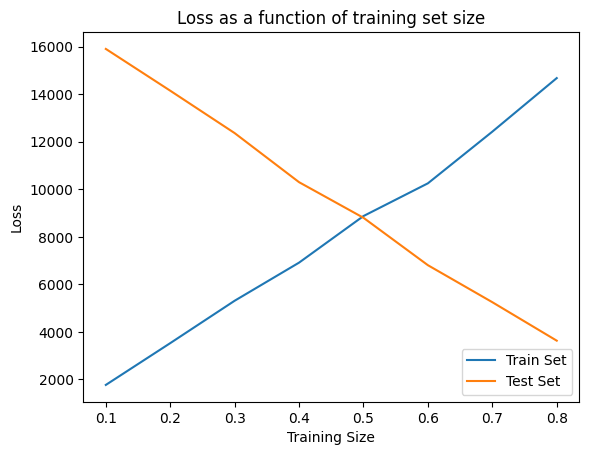

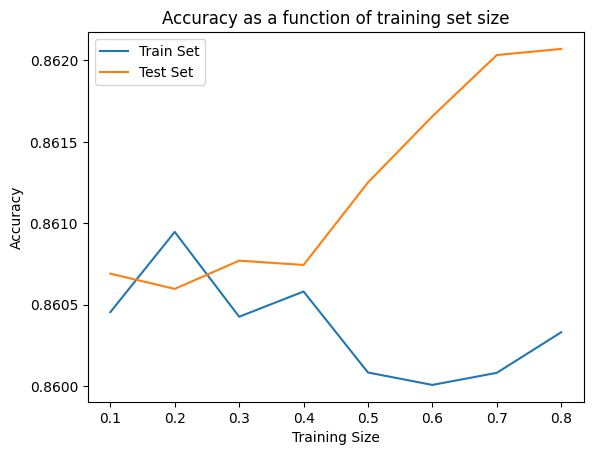

In [263]:
train_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
loss_scores = {'train': [], 'test': []}
acc_scores = {'train': [], 'test': []}

for i in range(1, 9):
  # get the test_size
  size = (10-i)*0.1

  # split data into train and test sets
  Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size=size, random_state=42)

  # train the model and
  model = LogisticRegressionMB()
  model.fit(Xd_train, yd_train)

  # make predictions for the train set
  yhd_train = model.predict(Xd_train)
  # get the loss for the train set
  train_loss = 0.5 * np.linalg.norm(yd_train - yhd_train) ** 2
  loss_scores['train'].append(train_loss)
  # get the accuracy for train set
  acc_train = accuracy_score(yd_train, yhd_train.astype(int))
  acc_scores['train'].append(acc_train)

  # make predictions for the test set
  yhd_test = model.predict(Xd_test)
  # get the loss for the test set
  test_loss = 0.5 * np.linalg.norm(yd_test - yhd_test) ** 2
  loss_scores['test'].append(test_loss)
  # get the accuracy for test set
  acc_test = accuracy_score(yd_test, yhd_test.astype(int))
  acc_scores['test'].append(acc_test)

  print(i, ' out of 8 done')

# plot for loss
plt.plot(train_sizes, loss_scores['train'], label='Train Set')
plt.plot(train_sizes, loss_scores['test'], label='Test Set')
plt.title('Loss as a function of training set size')
plt.xlabel('Training Size')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot for accuracy
plt.plot(train_sizes, acc_scores['train'], label='Train Set')
plt.plot(train_sizes, acc_scores['test'], label='Test Set')
plt.title('Accuracy as a function of training set size')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()





#Task 3.4: Test logistic regression mini batch with growing batch sizes.

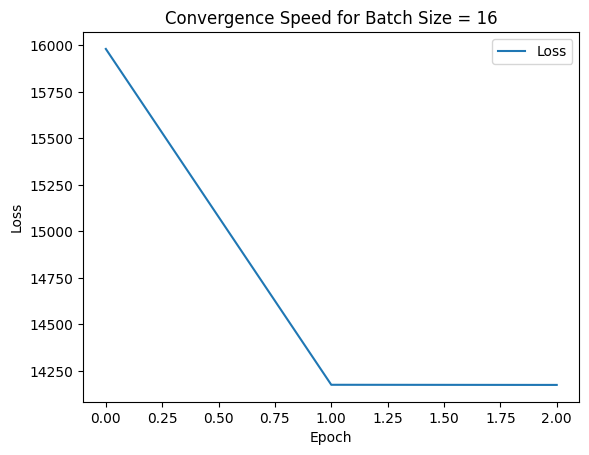

Accuracy:  0.8620900346893724


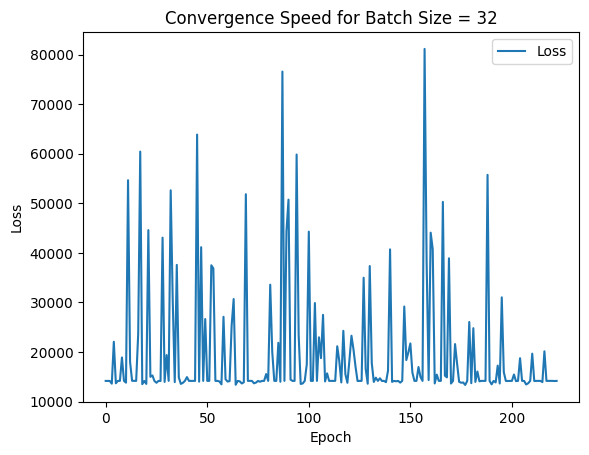

Accuracy:  0.8620900346893724


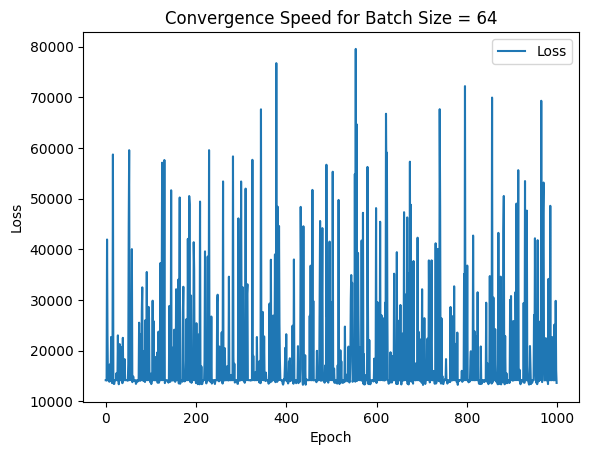

Accuracy:  0.8620111952065594


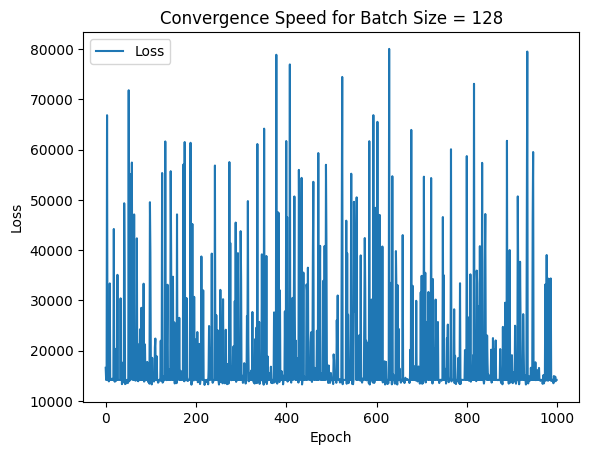

Accuracy:  0.8620900346893724


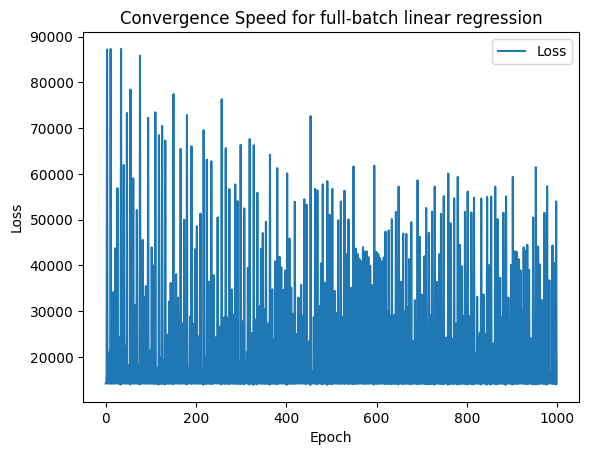

Accuracy:  0.8620900346893724


In [264]:
batch_sizes = [16, 32, 64, 128]

# split data into train and test sets
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size=size, random_state=42)

for i in range(0, 4):
  # get the test_size
  size = batch_sizes[i]

  # train the model and get predictions
  model = LogisticRegressionMB(bs=size, history = {'loss': []}, epochs=1000)
  yhd = model.fit(Xd_train, yd_train).predict(Xd_test)

  # get the convergence speed (basicly the list of loss functions to see how fast it approches 0)
  loss_speed = model.history['loss']

  # plot the convergence speed for the current batch size
  plt.plot(loss_speed, label='Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Convergence Speed for Batch Size = ' + str(size))
  plt.legend()
  plt.show()

  # get accuracy
  acc = accuracy_score(yd_test, yhd.astype(int))
  print('Accuracy: ', acc)


# test with full batch version
model = LogisticRegression(history = {'loss': []}, epochs=1000)
yhd = model.fit(Xd_train, yd_train).predict(Xd_test)

# get loss history
loss_speed = model.history['loss']

# plot the convergence speed for full-batch
plt.plot(loss_speed, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Convergence Speed for full-batch linear regression')
plt.legend()
plt.show()

# get accuracy
acc = accuracy_score(yd_test, yhd.astype(int))
print('Accuracy: ', acc)






As you can see in the above plots. The higher the batch size, the more oscilation there is, and the longer it takes to compute the gradients. For these reasons I belive that the best configuration is the smallest batch size.

#Task 3.5: Test logistic regression mini batch with 3 different learning rates.

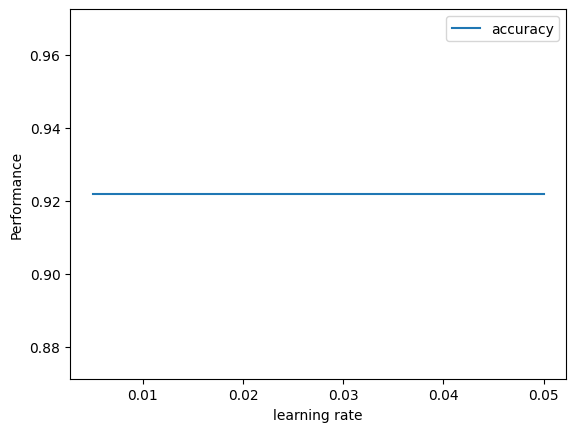

In [265]:
lrs = [0.005, 0.01, 0.05]
acc_scores = []

# split data into train and test sets
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size=size, random_state=42)

for i in range(0, 3):
  # get the test_size
  lr = lrs[i]

  # train the model and get predictions
  model = LogisticRegressionMB(lr=lr, epochs=100)
  yhd = model.fit(Xd_train, yd_train).predict(Xd_test)

  # display results
  acc = accuracy_score(yd_test, yhd.astype(int))
  acc_scores.append(acc)

# plot the curves
plt.plot(lrs, acc_scores, label='accuracy')
plt.xlabel('learning rate')
plt.ylabel('Performance')
plt.legend()
plt.show()